In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
%matplotlib inline

### Знакомство с данными

Попробуем посмотреть, что лежит в файле.

In [156]:
with open("SMSSpamCollection.txt", "r") as fin:
    print(fin.read().splitlines()[:10])

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'ham\tOk lar... Joking wif u oni...', "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'ham\tU dun say so early hor... U c already then say...', "ham\tNah I don't think he goes to usf, he lives around here though", "spam\tFreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv", 'ham\tEven my brother is not like to speak with me. They treat me like aids patent.', "ham\tAs per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune", 'spam\tWINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code

Ага, классы разделены от строк символами табуляции. Занчит можно использовать pandas.read_table, чтобы считать файл в удобном формате

In [157]:
df = pd.read_table("SMSSpamCollection.txt", names=["class", "document"], delimiter='\t')

In [158]:
df.head()

,class,document
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


       class                document
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30


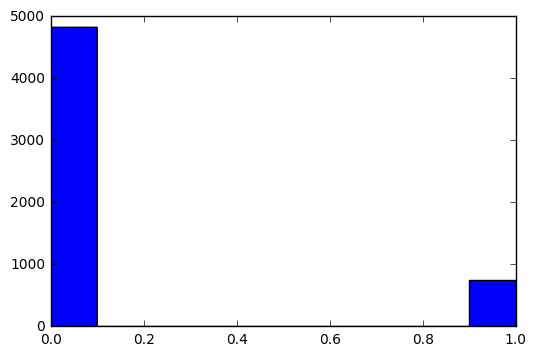

In [159]:
plt.hist(df.values[:, 0] == "spam")
print(df.describe())
plt.show()

Как видим, не спама сильно больше, чем спама и датасет не сбалансированный

### LogisticRegression

Попробуем обучить логистическую регрессию для предсказания

In [160]:
y = (df.values[:, 0] == "spam").astype('int')
data = df.values[:, 1]
vec = CountVectorizer()
X = vec.fit_transform(data)

In [161]:
def scoring(clf, X, y):
    return f1_score(y, clf.predict(X))
print(np.average(cross_val_score(LogisticRegression(), X, y, scoring=scoring, cv=10, n_jobs=4)))

0.932640298361


In [163]:
X_test = ["FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GB",
"FreeMsg: Txt: claim your reward of 3 hours talk time",
"Have you visited the last lecture on physics?",
"Have you visited the last lecture on physics? Just buy this book and you will have all materials! Only 99$",
"Only 99$"]
X_test = vec.transform(X_test)
clf = LogisticRegression()
clf.fit(X, y)
print(" ".join(map(str, clf.predict(X_test))))

1 1 0 0 0


### ngrams

Попробуем воспользоваться энграммами. Сначал биграммами, потом триграммами, и наконец, уни + би + триграммами

In [179]:
def test_uni_bi_tri(clf):
    for ngram_range in [(2, 2), (3, 3), (1, 3)]:
        vec = CountVectorizer(ngram_range=ngram_range)
        X = vec.fit_transform(data)
        ans = np.average(cross_val_score(clf, X, y, scoring=scoring, cv=10, n_jobs=4))
        print("{} {} {:.2f}".format(type(clf).__name__, ngram_range, ans))

In [180]:
test_uni_bi_tri(LogisticRegression())

LogisticRegression (2, 2) 0.82
LogisticRegression (3, 3) 0.73
LogisticRegression (1, 3) 0.93


Как видно, только лишь биграмы или триграмы ухучшили предсказания, в наивном байесе ситуация еще хуже

In [181]:
test_uni_bi_tri(MultinomialNB())

MultinomialNB (2, 2) 0.65
MultinomialNB (3, 3) 0.38
MultinomialNB (1, 3) 0.89


### TfIdf

TfIdf на данном датасете сработал плохо

In [90]:
vec = TfidfVectorizer()
X = vec.fit_transform(data)
print(np.average(cross_val_score(LogisticRegression(), X, y, scoring=scoring, cv=10, n_jobs=4)))

0.852859955417


### gridsearch

Воспользуемся grid search для подбора оптимальных параметров CountVectorizer и LogisticRegression

In [123]:
params = {"regr__max_iter": [100, 200],
          "regr__dual": [True, False],
          "regr__C": [3.0, 1.0, 0.5, 0.1],
          #"regr__penalty": ["l1", "l2"],
          "vec__stop_words": [None, "english"],
          "vec__binary": [True, False],
          "vec__max_features": [None, 3000]}
pipeline = Pipeline(steps = [('vec', CountVectorizer()), ('regr', LogisticRegression())])
gs = GridSearchCV(pipeline, params, cv=10, scoring=scoring, n_jobs=4)
gs.fit(data, y)
print(gs.best_params_)
gs.best_score_

{'vec__stop_words': None, 'regr__dual': True, 'vec__max_features': None, 'regr__C': 3.0, 'regr__max_iter': 100, 'vec__binary': True}


0.94184436657943815

Бинарные признаки сработали лучше, чем целочисленные. Оптимальный параметр обратной силы регуляризации $C = 3$. Введение стоп слов не помогло. Раз бинарные признаки сработали лучше, проверим BernoulliNB на них (просто так)

In [153]:
np.average(cross_val_score(BernoulliNB(), CountVectorizer(binary=True).fit_transform(data), y, scoring, 10, 4))

0.92780473789296936

### Выводы

Логистическая регрессия сработала хорошо, энграммы не улучшили качество, так как датасет слишком маленький (5000 объектов, а одних только биграм сильно больше). TfIdf в данном случае не помог, но это еще не значит, что он будет плохо работать на каждом датасете. Наивный байес работал хуже логистической регрессии. grid search показал, что оптимальная сила регуляризации меньше, чем стандратная и что бинарные признаки на данном датасете работают лучше, чем целочисленные. BernoulliNB на бинарных работает лучше чем MultinomialNB на целочисленных